#### About this repository:

The notebooks in this repository are meant to serve as comprehensive building blocks for establishing an algorithmic trading system. 
 
A number of sample trading strategies are included, along with methodologies to determine their robustness. Walk-Forward Analysis is one such well known technique, while Combinatorial Purged Cross Validation is a newer and more  rigorous methodology. Another useful and important concept is Meta Labelling, which predicts the probability of individual winning trades. All three techniques are utilized here to help improve the rigor of the systematic trading research process. 

Even though the methodologies presented in these notebooks can always be fine-tuned further, they are sophisticated enough to provide rigorous backtesting of any algorithmic trading strategy. After looking through this repository, one should gain an understanding of how algorithmic trading startegies are programmed and backtested. Identifying such strategies can simply be a matter of adapting algorithms found in research journals or trading websites; the aim of these notebooks is to determine a strategy's profitability and robustness. The final step of live trading a strategy should be merely trivial rewriting of a few lines of code in the Zipline version of the strategy. 


*Hoa Tuan Nguyen:* http://linkedin.com/in/hoatuannguyen/

## Walk-Forward Analysis with Mixed Bollinger Bands Strategy:

This notebook carries out the Walk-Forward Analysis (WFA) for my Mixed Bollinger Band strategy. 

While the functions in this notebook were written specifically to work with this strategy, it should take only a few minor tweaks to apply the WFA as implemented here to another strategy. Due to time constraint and a lack of immediate needs, the walk_forward function in this notebook (and similar functions in this repository) was not written to work seamlessly for any strategy. Some slight modifications are always required. 

The idea behind a WFA is simple: a trading strategy is optimized over a small train period, and the  best parameters' values are used to run the strategy on an out-of-sample test set. This process is repeated as we 'walk forward' in time - optimizing and testing on new data such that in the end, we attain the out-of-sample performance of the strategy for a period of one year or longer. 

In order to avoid overfitting to a small train period, we should first optimize the strategy over a long time window that includes multiple market types for the securities or set of securities of interest (note: make sure not to carry out the WFA on this same set of data later). This step will yield the optimized parameters' space where our strategy is profitable across different types of markets. We can then use this parameters' space in the objective function for our WFA.

Walk-Forward Analysis provides a simple yet effective method to determine the robustness of any trading strategy. That said, our strategy in the end is still only backtested on one particular realization of the random path of the security's prices. It would obviously be better if we can carry out WFA on a longer time period of multiple years. However, this is not always possible. To address this drawback, we will resort to Combinatorial Purged Cross Validation, a technique explored in another notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('ticks')
%matplotlib inline

import optuna
import empyrical
import pyfolio

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
df = pd.read_csv('data/btc_2019_aug6_2020.csv', index_col=0, parse_dates=True)

In [3]:
df.head()

,close,high,low,open,volume
2019-01-01 00:00:00+00:00,3694.5,3694.5,3693.0,3693.0,241.351087
2019-01-01 00:01:00+00:00,3690.5,3694.5,3690.5,3694.5,178.451678
2019-01-01 00:02:00+00:00,3690.5,3691.0,3690.5,3690.5,53.144116
2019-01-01 00:03:00+00:00,3690.0,3691.0,3690.0,3690.5,71.344447
2019-01-01 00:04:00+00:00,3688.5,3690.5,3688.5,3690.5,194.159810


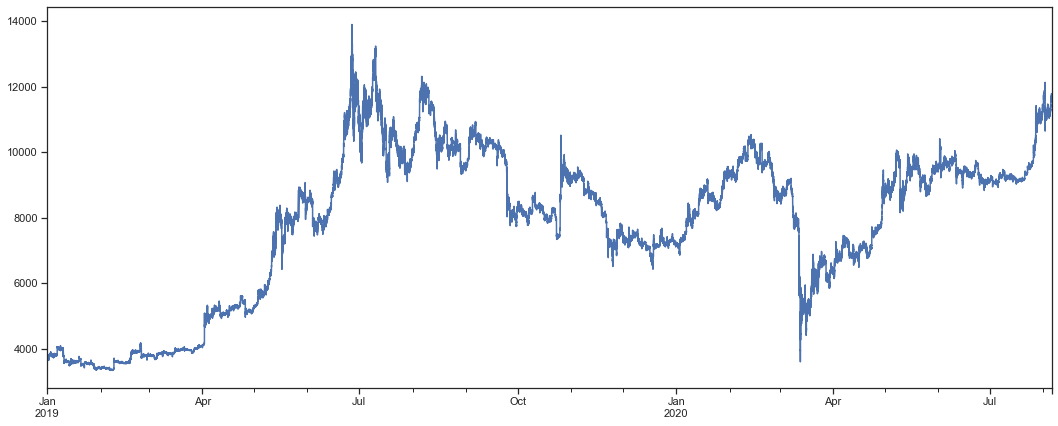

In [4]:
df.close.plot(figsize=(18,7))

In [5]:
# Function to calculate Pessimistic Return on Margin from a cumulative return pandas series

def PROM(cumRet):
    trade_rets = (cumRet-cumRet.shift(1).fillna(1))
    win_trades = trade_rets[trade_rets>0]
    lose_trades = trade_rets[trade_rets<0]
    adj_wins = len(win_trades) - np.sqrt(len(win_trades))
    adj_losses = len(lose_trades) + np.sqrt(len(lose_trades))
    avg_win = win_trades.mean()
    avg_lose = lose_trades.mean()
    return avg_win*adj_wins+avg_lose*adj_losses

In [6]:
# helper function that returns daily returns for non-continuous cummulative returns

def dailyRet_noncont(cumRet):
    cumRet = cumRet.resample('1T').mean().fillna(method='ffill')
    return (cumRet.resample('1D').last()/cumRet.resample('1D').last().shift(1)-1).dropna()

In [7]:
def mixed_strategy_WF(data, start_cap, slow, fast, mult_std, pt=.04, sl=-.012):
    lower_breached = False
    upper_breached = False
    long_pos = False
    short_pos = False
    
    can_close = False
    sideways_on = False
    trending_on = False  
    
    longs = 0
    shorts = 0
    filled_price = 0
    PnL = start_cap
    cumRet = []
    
    data['sma_long'] = data.close.shift(1).rolling(slow).mean()
    data['std_long'] = data.close.shift(1).rolling(slow).std()
    data['sma_short'] = data.close.shift(1).rolling(fast).mean()
    data['upper'] = data['sma_long'] + mult_std*data['std_long']
    data['lower'] = data['sma_long'] - mult_std*data['std_long']
    data.dropna(inplace=True)

    for row in data.itertuples():
        current_price = row.close
        upper = row.upper
        lower = row.lower
        slow_mva = row.sma_long
        fast_mva = row.sma_short
        has_pos = long_pos + short_pos
        
        # put on trending trades
        if fast_mva >= upper and not upper_breached and not has_pos and current_price <= fast_mva*1.005:
            filled_price = current_price
            long_pos = True
            longs += 1
            upper_breached = True
            trending_on = True
        elif fast_mva <= lower and not lower_breached and not has_pos and current_price >= fast_mva*0.995:
            filled_price = current_price
            short_pos = True
            shorts += 1
            lower_breached = True
            trending_on = True

        # put on sideways trades
        elif not has_pos and lower_breached and fast_mva >= lower and current_price <= fast_mva*1.005:
            filled_price = current_price
            long_pos = True
            longs += 1
            lower_breached = False
            sideways_on = True
        elif not has_pos and upper_breached and fast_mva <= upper and current_price >= fast_mva*0.995:
            filled_price = current_price
            short_pos = True
            shorts += 1
            upper_breached = False
            sideways_on = True
        
        # take profits or stop loss on short trending trade
        elif trending_on and short_pos:
            prct_changed = (filled_price - current_price) / filled_price
            if not can_close and abs(prct_changed) >= .01:
                can_close = True
            if fast_mva >= lower and can_close:
                short_pos = False
                PnL *= (1+prct_changed)    # record realized PnL
                lower_breached = False
                can_close = False
            else:
                if prct_changed >= pt*1.75:
                    short_pos = False
                    PnL *= (1+prct_changed)
                    can_close = False
                    trending_on = False
                elif prct_changed <= sl*1.5:
                    short_pos = False
                    PnL *= (1+prct_changed)
                    can_close = False
                    trending_on = False

        # take profits or stop loss on long trending trade
        elif trending_on and long_pos:
            prct_changed = (current_price - filled_price) / filled_price
            if not can_close and prct_changed >= .01:
                can_close = True
            if fast_mva <= upper and can_close:
                long_pos = False
                PnL *= (1+prct_changed) 
                upper_breached = False
                can_close = False
                trending_on = False
            else:
                if prct_changed >= pt*1.75:
                    long_pos = False
                    PnL *= (1+prct_changed) 
                    can_close = False
                    trending_on = False
                elif prct_changed <= sl*1.5:
                    long_pos = False
                    PnL *= (1+prct_changed) 
                    can_close = False
                    trending_on = False
        
        # take off short sideways trade
        elif sideways_on and short_pos:
            prct_changed = (filled_price - current_price) / filled_price
            if fast_mva <= slow_mva:
                short_pos = False
                PnL *= (1+prct_changed)
                sideways_on = False
            elif prct_changed >= pt:
                short_pos = False
                PnL *= (1+prct_changed)
                sideways_on = False
            elif prct_changed <= sl:
                short_pos = False
                PnL *= (1+prct_changed)
                sideways_on = False

        # take off long sideways trade
        elif sideways_on and long_pos:
            prct_changed = (fast_mva - current_price) / filled_price
            if fast_mva >= slow_mva:
                long_pos = False
                PnL *= (1+prct_changed)
                sideways_on = False
            elif prct_changed >= pt:
                long_pos = False
                PnL *= (1+prct_changed)
                sideways_on = False
            elif prct_changed <= sl:
                long_pos = False
                PnL *= (1+prct_changed)
                sideways_on = False
  
                
        # reset bands breached flags if price within range
        elif fast_mva > lower and fast_mva < upper and upper_breached+lower_breached:
            lower_breached = False
            upper_breached = False
            
        cumRet.append(PnL)
    cumRet = pd.Series(cumRet, index=data.index)      
    return cumRet, PROM(cumRet)+empyrical.max_drawdown(dailyRet_noncont(cumRet)), longs, shorts

In [8]:
def wf_obj(trial, data):
    slow = int(trial.suggest_discrete_uniform('slow', 5400, 6000, 50))
    fast = int(trial.suggest_discrete_uniform('fast', 340, 410, 5))
    mult = trial.suggest_discrete_uniform('mult', 2.15, 2.35, .02)
    return mixed_strategy_WF(data.copy(), 1, slow, fast, mult)[1]

In [9]:
# data should start two months before the first test period
# might be best to start a test period in the middle of a month since each new month might have a new behavior
# starting at the middle captures some of the behavior of a month
# wf_df = df.loc['2019-05-15':]

# this version of walk_forward function depends on the implementation of the objective function for the particular
# problem at hands

def walk_forward(data, objective, num_test_periods=12, num_trials=60):
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    test_len = int(data.shape[0]/num_test_periods)
    train_len = test_len * 2
    cumRet = pd.Series(dtype='float64')
    longs = 0
    shorts = 0
    for i in range(train_len, data.shape[0], test_len):
        train_df = data.iloc[i-train_len:i, :]
        test_df = data.iloc[i:i+test_len, :]
        print('train: ', train_df.index[0], ' to ', train_df.index[-1], 
              '\ntest: ', test_df.index[0], ' to ', test_df.index[-1])
        
        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: objective(trial, train_df.copy()), n_trials=num_trials)
        
        bp = study.best_params
        print(bp, ' with best value: ', study.best_value, '\n')
        
        slow = int(bp['slow'])
        fast = int(bp['fast'])
        mult = int(bp['mult'])
        sc = 1 if len(cumRet) == 0 else cumRet[-1]
        cr, pm, l, s = mixed_strategy_WF(test_df.copy(), sc, slow, fast, mult)
        longs += l
        shorts += s
        cumRet = pd.concat([cumRet, cr])
    return cumRet, longs, shorts

In [10]:
def PROM2(cumRet):
    trade_rets = (cumRet-cumRet.shift(1).fillna(1))
    win_trades = trade_rets[trade_rets>0]
    lose_trades = trade_rets[trade_rets<0]
    adj_wins = len(win_trades) - np.sqrt(len(win_trades))
    adj_losses = len(lose_trades) + np.sqrt(len(lose_trades))
    avg_win = win_trades.mean()
    avg_lose = lose_trades.mean()
    return avg_win*adj_wins+avg_lose*adj_losses, win_trades, lose_trades

In [11]:
def dailyRet_WF(cumRet):
    cumRet = cumRet.resample('1T').mean()
    cumRet.fillna(method='ffill', inplace=True)
    return cumRet.resample('1D').apply(lambda x: x[-1]/x[0]-1)

In [12]:
cumRet, longs, shorts = walk_forward(df.loc['2019-07-01':].copy(), wf_obj, 13, 80)

train:  2019-07-01 00:00:00+00:00  to  2019-08-31 20:17:00+00:00 
test:  2019-08-31 20:18:00+00:00  to  2019-10-01 18:26:00+00:00


[W 2020-08-08 01:00:21,710] Trial 52 failed, because the objective function returned nan.
[W 2020-08-08 01:00:21,943] Trial 53 failed, because the objective function returned nan.
[W 2020-08-08 01:00:22,184] Trial 54 failed, because the objective function returned nan.
[W 2020-08-08 01:00:22,518] Trial 55 failed, because the objective function returned nan.
[W 2020-08-08 01:00:23,234] Trial 58 failed, because the objective function returned nan.
[W 2020-08-08 01:00:23,565] Trial 59 failed, because the objective function returned nan.
[W 2020-08-08 01:00:23,819] Trial 60 failed, because the objective function returned nan.
[W 2020-08-08 01:00:24,062] Trial 61 failed, because the objective function returned nan.
[W 2020-08-08 01:00:24,385] Trial 62 failed, because the objective function returned nan.
[W 2020-08-08 01:00:24,647] Trial 63 failed, because the objective function returned nan.
[W 2020-08-08 01:00:24,892] Trial 64 failed, because the objective function returned nan.
[W 2020-08

{'slow': 5500.0, 'fast': 345.0, 'mult': 2.17}  with best value:  0.15254599387875034 

train:  2019-07-31 22:09:00+00:00  to  2019-10-01 18:26:00+00:00 
test:  2019-10-01 18:27:00+00:00  to  2019-11-01 16:35:00+00:00
{'slow': 5800.0, 'fast': 370.0, 'mult': 2.21}  with best value:  0.07340206363969465 

train:  2019-08-31 20:18:00+00:00  to  2019-11-01 16:35:00+00:00 
test:  2019-11-01 16:36:00+00:00  to  2019-12-02 14:44:00+00:00
{'slow': 5950.0, 'fast': 345.0, 'mult': 2.19}  with best value:  -0.05987243250544751 

train:  2019-10-01 18:27:00+00:00  to  2019-12-02 14:44:00+00:00 
test:  2019-12-02 14:45:00+00:00  to  2020-01-02 12:53:00+00:00
{'slow': 5400.0, 'fast': 370.0, 'mult': 2.35}  with best value:  -0.04743111257544751 

train:  2019-11-01 16:36:00+00:00  to  2020-01-02 12:53:00+00:00 
test:  2020-01-02 12:54:00+00:00  to  2020-02-02 11:02:00+00:00
{'slow': 6000.0, 'fast': 370.0, 'mult': 2.25}  with best value:  -0.011067680614665194 

train:  2019-12-02 14:45:00+00:00  to  20

<ipython-input-7-6cf2bcd88aaf>:143: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cumRet = pd.Series(cumRet, index=data.index)


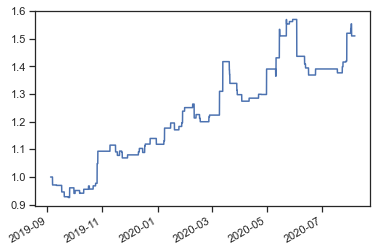

In [13]:
cumRet.plot()

In [16]:
prom, wins, losses = PROM2(cumRet)

In [19]:
print('Pessimistic Return on Margin: ', prom)
print('PROM to Return: ', prom/(cumRet[-1]-1))
print('# wins: ', wins.shape[0])
print('# losses: ', losses.shape[0])
print('# longs: ', longs)
print('# shorts: ', shorts)
print('max drawdown: ', empyrical.max_drawdown(dailyRet_WF(cumRet)))

Pessimistic Return on Margin:  0.18339347418391894
PROM to Return:  0.3594209287345426
# wins:  45
# losses:  34
# longs:  37
# shorts:  42
max drawdown:  -0.12801998257854869
